In [13]:
# Mount Google Drive untuk penyimpanan permanen
from google.colab import drive
drive.mount('/content/drive')

# Instal library yang diperlukan
!pip install yfinance pandas numpy scikit-learn tensorflow ta plotly joblib matplotlib -q

# Import libraries
import os
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

print("✅ Setup selesai. Drive terhubung.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup selesai. Drive terhubung.


In [14]:
# --- KONFIGURASI KHUSUS SAHAM BBCA ---
CONFIG = {
    'ticker': 'BBCA.JK',       # Ticker Yahoo Finance untuk BBCA
    'start_date': '2021-01-01', # Sesuai rentang data skripsi
    'end_date': '2025-12-31',
    'sequence_length': 60,     # Window size (Sesuai PDF)
    'train_split': 0.8,        # 80% Train, 20% Test
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001
}

# --- PATH PENYIMPANAN DI GOOGLE DRIVE ---
BASE_DIR = '/content/drive/MyDrive/BBCAPredictionGold'
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(f'{BASE_DIR}/artifacts', exist_ok=True)
os.makedirs(f'{BASE_DIR}/plots', exist_ok=True)

MODEL_PATH = f'{BASE_DIR}/artifacts/best_bbca_lstm_model.keras'
SCALER_PATH = f'{BASE_DIR}/artifacts/scaler.pkl'

print(f"📂 Proyek BBCA akan disimpan di: {BASE_DIR}")

📂 Proyek BBCA akan disimpan di: /content/drive/MyDrive/BBCAPredictionGold


In [15]:
def load_and_engineer_features(ticker, start, end):
    print("📥 Mengunduh data saham BBCA dari Yahoo Finance...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Handle multi-level columns jika ada (versi yfinance terbaru)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if len(df) == 0:
        raise Exception("Data BBCA tidak ditemukan. Periksa koneksi internet atau ticker.")

    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # --- INDIKATOR TEKNIKAL (Sesuai Bab 2.5 PDF) ---
    print("🛠️ Menghitung Indikator Teknikal...")

    # 1. SMA (Simple Moving Average)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # 2. EMA (Exponential Moving Average)
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # 3. RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 4. MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # 5. Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)

    df.dropna(inplace=True)
    return df

# Eksekusi
df = load_and_engineer_features(CONFIG['ticker'], CONFIG['start_date'], CONFIG['end_date'])
print(f"✅ Data BBCA siap. Total baris: {len(df)}")
df.head()

📥 Mengunduh data saham BBCA dari Yahoo Finance...
🛠️ Menghitung Indikator Teknikal...
✅ Data BBCA siap. Total baris: 1186


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI,MACD,Signal_Line,BB_middle,BB_upper,BB_lower
Date,,,,,,,,,,,,,
2021-01-29,5962.226074,6173.902740,5962.226074,6085.704129,132762500,6185.147632,6133.658497,24.454181,-11.951422,23.707831,6185.147632,6437.895967,5932.399297
2021-02-01,6015.145020,6103.343627,5816.698153,5962.225855,113129000,6184.486182,6122.371499,33.333333,-19.376199,15.091025,6184.486182,6439.024917,5929.947446
2021-02-02,5997.504883,6156.262365,5997.504883,6143.032575,86741000,6171.697363,6110.479440,33.999997,-26.379711,6.796878,6171.697363,6437.150507,5906.244219
2021-02-03,6019.555664,6173.903245,6019.555664,6173.903245,67291000,6166.405493,6101.820033,39.459541,-29.807133,-0.523924,6166.405493,6439.844968,5892.966018
2021-02-04,6046.014648,6173.902632,6028.374927,6103.343744,80950500,6161.554565,6096.505234,44.382054,-30.042064,-6.427552,6161.554565,6440.133859,5882.975272


In [16]:
# Fitur yang akan digunakan untuk training (Urutan harus konsisten)
features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'BB_upper', 'BB_lower']
data_subset = df[features].values

# --- Scaling (MinMax Scaler) ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_subset)

# --- Membuat Sequences ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])  # Target adalah Close Price (index 0)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, CONFIG['sequence_length'])

# --- Splitting Data (80:20 Chronological) ---
split_idx = int(len(X) * CONFIG['train_split'])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Simpan scaler
joblib.dump(scaler, SCALER_PATH)
print(f"💾 Scaler disimpan di {SCALER_PATH}")
print(f"📊 Shape Train: {X_train.shape}, Test: {X_test.shape}")

💾 Scaler disimpan di /content/drive/MyDrive/BBCAPredictionGold/artifacts/scaler.pkl
📊 Shape Train: (900, 60, 7), Test: (226, 60, 7)


In [17]:
def build_lstm_model(input_shape):
    model = Sequential()

    # Layer 1
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Layer 2
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Dense Layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compiler (Sesuai PDF: Adam lr=0.001, Loss=MSE)
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,433 (478.25 KB)

 Trainable params: 122,049 (476.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [18]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)
]

print("🚀 Memulai Pelatihan Model Prediksi Saham BBCA...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

print(f"✅ Model terbaik disimpan di {MODEL_PATH}")

🚀 Memulai Pelatihan Model Prediksi Saham BBCA...
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.8420 - mae: 0.6856 - mse: 0.8420
Epoch 1: val_loss improved from inf to 0.11224, saving model to /content/drive/MyDrive/BBCAPredictionGold/artifacts/best_bbca_lstm_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 318ms/step - loss: 0.8286 - mae: 0.6789 - mse: 0.8286 - val_loss: 0.1122 - val_mae: 0.3235 - val_mse: 0.1122 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1647 - mae: 0.3186 - mse: 0.1647
Epoch 2: val_loss did not improve from 0.11224
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.1640 - mae: 0.3179 - mse: 0.1640 - val_loss: 0.1666 - val_mae: 0.3985 - val_mse: 0.1666 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0884 - mae: 0.2353 - mse: 0.0884
Epoch 3: val_loss did not improve from 0.11224
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0883 - mae: 0.2352 - mse: 0.0883 - val_loss: 0.1

In [19]:
# Prediksi
predictions_scaled = model.predict(X_test)

# --- PERBAIKAN INVERSE TRANSFORM ---
# Karena scaler di-fit pada 7 fitur, kita harus membuat array dummy dengan 7 kolom
# untuk melakukan inverse transform dengan benar.

n_features = len(features)
n_samples = len(predictions_scaled)

# 1. Buat array dummy untuk prediksi
pred_dummy = np.zeros((n_samples, n_features))
pred_dummy[:, 0] = predictions_scaled.flatten() # Isi kolom Close (index 0)

# 2. Buat array dummy untuk aktual
actual_dummy = np.zeros((n_samples, n_features))
actual_dummy[:, 0] = y_test.flatten() # Isi kolom Close (index 0)

# 3. Inverse Transform menggunakan scaler yang disimpan
predictions_real = scaler.inverse_transform(pred_dummy)[:, 0]
actuals_real = scaler.inverse_transform(actual_dummy)[:, 0]

# --- Metrik Evaluasi ---
mae = mean_absolute_error(actuals_real, predictions_real)
rmse = np.sqrt(mean_squared_error(actuals_real, predictions_real))
mape = np.mean(np.abs((actuals_real - predictions_real) / actuals_real)) * 100
r2 = r2_score(actuals_real, predictions_real)

# Direction Accuracy
actual_direction = np.sign(np.diff(actuals_real))
pred_direction = np.sign(np.diff(predictions_real))
direction_acc = np.mean(actual_direction == pred_direction) * 100

print("\n" + "="*40)
print("📊 HASIL EVALUASI KINERJA MODEL (BBCA)")
print("="*40)
print(f"✅ MAE             : {mae:.2f}")
print(f"✅ RMSE            : {rmse:.2f}")
print(f"✅ MAPE            : {mape:.2f}%")
print(f"✅ R-Square (R²)   : {r2:.4f}")
print(f"✅ Direction Acc   : {direction_acc:.2f}%")
print("="*40)

# Simpan hasil evaluasi
with open(f'{BASE_DIR}/evaluation_results.txt', 'w') as f:
    f.write(f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR2: {r2:.4f}\nDir_Acc: {direction_acc:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step

📊 HASIL EVALUASI KINERJA MODEL (BBCA)
✅ MAE             : 214.05
✅ RMSE            : 277.39
✅ MAPE            : 2.53%
✅ R-Square (R²)   : 0.6871
✅ Direction Acc   : 47.11%


📸 Grafik disimpan di /content/drive/MyDrive/BBCAPredictionGold/plots/


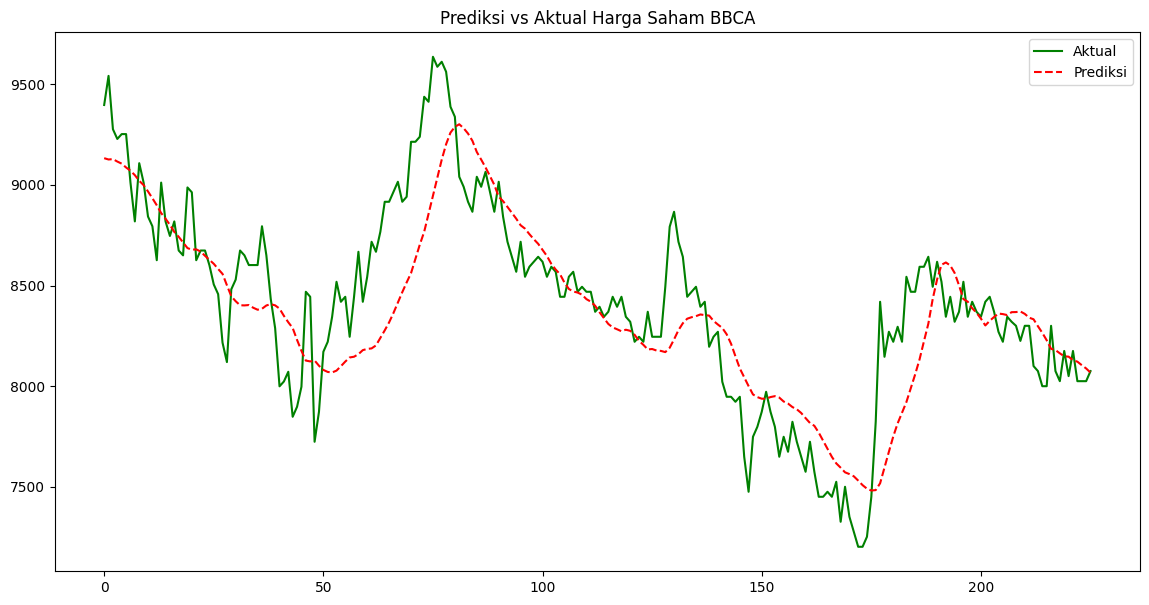

In [20]:
# Siapkan data tanggal untuk plot
# Karena sequence length, tanggal test dimulai dari index tertentu
test_dates = df.index[-len(actuals_real):]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_dates, y=actuals_real,
    mode='lines', name='Harga Aktual BBCA',
    line=dict(color='green', width=2)
))

fig.add_trace(go.Scatter(
    x=test_dates, y=predictions_real,
    mode='lines', name='Harga Prediksi BBCA',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title=f'Prediksi Harga Saham BBCA vs Aktual (Data Test)',
    xaxis_title='Tanggal',
    yaxis_title='Harga (IDR)',
    template='plotly_dark',
    hovermode='x unified'
)

fig.show()

# Simpan gambar statis
plt.figure(figsize=(14, 7))
plt.plot(actuals_real, label='Aktual', color='green')
plt.plot(predictions_real, label='Prediksi', color='red', linestyle='--')
plt.title('Prediksi vs Aktual Harga Saham BBCA')
plt.legend()
plt.savefig(f'{BASE_DIR}/plots/bbca_prediction_comparison.png', dpi=300)
print(f"📸 Grafik disimpan di {BASE_DIR}/plots/")

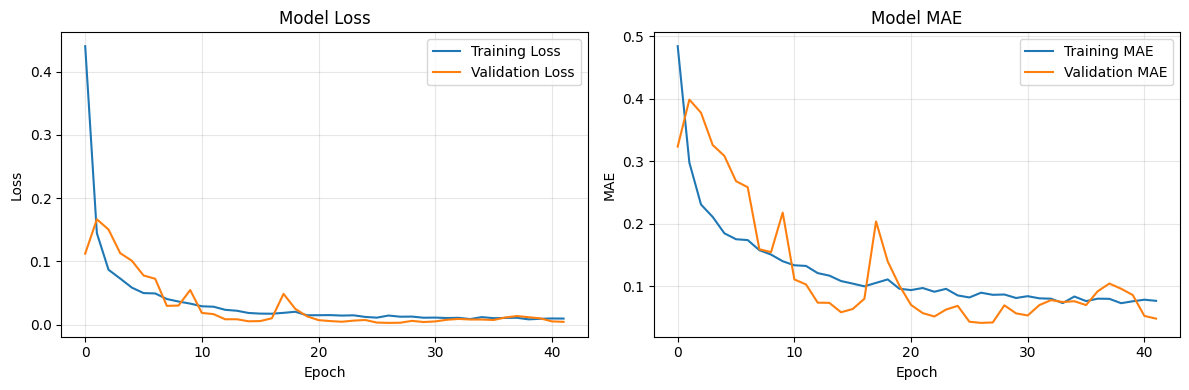

In [21]:
# Visualisasi training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()